## Importing Required Libraries

In [109]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) #For displaying all the columns of dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
import pickle

## Helper Functions

In [110]:
def extract_date_hour(dataset, col):
    '''This function will create two columns containing Hours and Minutes
       extracted from `col` column and then dropped it from the dataset.'''
    
    dataset[col + '_hour'] = dataset[col].dt.hour
    dataset[col + '_minute'] = dataset[col].dt.minute
    dataset.drop(col, axis=1, inplace=True)
    
    return dataset

## Loading Dataset

In [111]:
df = pd.read_excel('Data_Train.xlsx')
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662


## Exploratory Data Analysis | Feature Engineering

In [112]:
df.isnull().sum().sum()

2

#### As the Nan values are less, so dropping it.

In [113]:
df.dropna(inplace=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


### Working with Datetime columns
#### As the columns are of object type, converting them to datetime.

In [115]:
# Changing the datatype from object to datetime. 
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time']        = pd.to_datetime(df['Dep_Time'])
df['Arrival_Time']    = pd.to_datetime(df['Arrival_Time'])


#Extracting Day and Month.
df['Day']   = df['Date_of_Journey'].dt.day
df['Month'] = df['Date_of_Journey'].dt.month
df.drop('Date_of_Journey', axis=1, inplace=True)


#Extracting Hour and Minute.
df = extract_date_hour(df, 'Arrival_Time')
df = extract_date_hour(df, 'Dep_Time')

In [116]:
df.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,13,15,5,50


### Cleaning the 'Duration' column

In [117]:
duration = list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i]=duration[i] + ' 0m'
        else:
            duration[i]='0h '+ duration[i]

df['Duration'] = duration

In [118]:
df['Hour']   = df['Duration'].apply(lambda x:x.split(' ')[0][0:-1]).astype('int32')
df['Minute'] = df['Duration'].apply(lambda x:x.split(' ')[1][0:-1]).astype('int32')
df.drop('Duration', axis=1, inplace=True)
df.head(2)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute,Hour,Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,13,15,5,50,7,25


### Working with Categorical Columns

In [119]:
cat = [i for i in df.columns if df[i].dtype == 'O']
cat

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

### Working with Airlines columns

In [120]:
px.histogram(data_frame=df, x='Airline', y='Price')

In [121]:
px.box(data_frame=df.sort_values('Price',ascending=False), x='Airline', y='Price')

#### Clearly, Jet Airway has the maximum price range.

### Working with Total_Stops

In [122]:
px.histogram(data_frame=df, x='Total_Stops', y='Price', width=600, height=400)

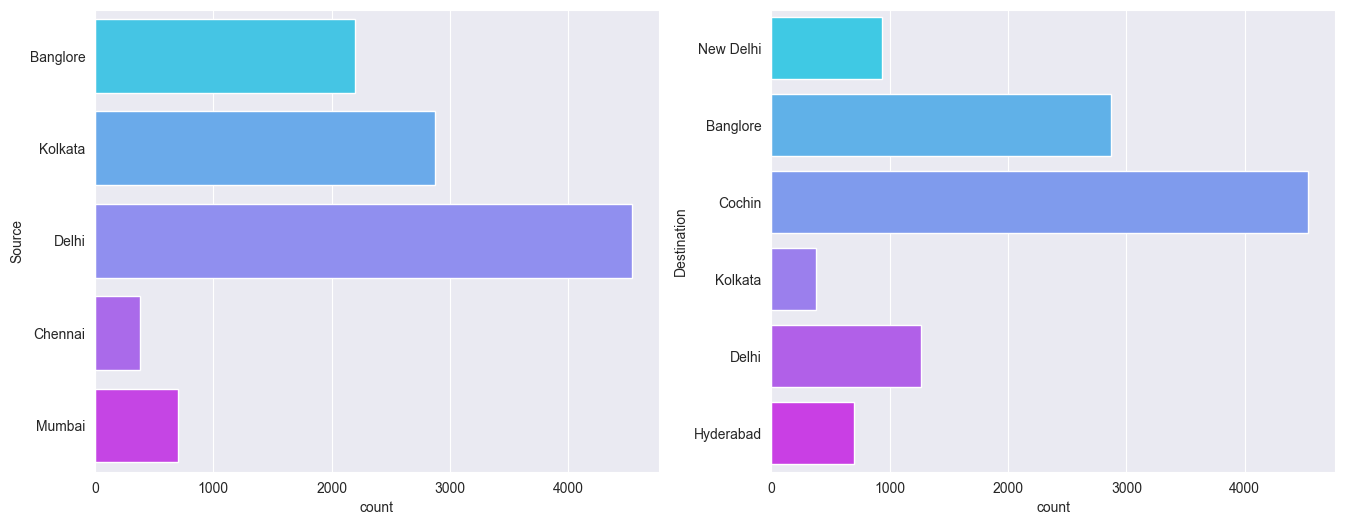

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(df['Source'], palette='cool', ax=ax[0])
sns.countplot(df['Destination'], palette='cool', ax=ax[1])
plt.show()

### Cleaning the 'Route' column

In [124]:
df['Route_1']=df['Route'].str.split('→').str[0]
df['Route_2']=df['Route'].str.split('→').str[1]
df['Route_3']=df['Route'].str.split('→').str[2]
df['Route_4']=df['Route'].str.split('→').str[3]
df['Route_5']=df['Route'].str.split('→').str[4]


df['Route_1'].fillna('None',inplace=True)
df['Route_2'].fillna('None',inplace=True)
df['Route_3'].fillna('None',inplace=True)
df['Route_4'].fillna('None',inplace=True)
df['Route_5'].fillna('None',inplace=True)

In [125]:
df['Additional_Info'].value_counts()
df.head(2)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute,Hour,Minute,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,1,10,22,20,2,50,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,13,15,5,50,7,25,CCU,IXR,BBI,BLR,None


#### Clearly, this column mostly contains No info, so it is of no use.

## Encoding categorical data

In [126]:
df[cat].head(3)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info


In [127]:
airline = pd.get_dummies(df['Airline'])
source  = pd.get_dummies(df['Source'])
desti   = pd.get_dummies(df['Destination'])
t_stops = pd.get_dummies(df['Total_Stops'])

In [128]:
label = LabelEncoder()
for i in ["Route_1","Route_2","Route_3","Route_4","Route_5"]:
    df[i] = label.fit_transform(df[i])

## Dropping unnesessary columns

In [129]:
df.drop(['Airline', 'Source', 'Destination', 'Route', 'Additional_Info', 'Total_Stops'],
       axis=1, inplace=True)

## Merging the cleaned Dataset

In [130]:
data = pd.concat([df, airline, source, desti, t_stops], axis=1)
data.head(2)

,Price,Day,Month,Arrival_Time_hour,Arrival_Time_minute,Dep_Time_hour,Dep_Time_minute,Hour,Minute,Route_1,Route_2,Route_3,Route_4,Route_5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Banglore,Chennai,Delhi,Kolkata,Mumbai,Banglore,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,1 stop,2 stops,3 stops,4 stops,non-stop
0,3897,24,3,1,10,22,20,2,50,0,13,29,13,5,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
1,7662,1,5,13,15,5,50,7,25,2,25,1,3,5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False


## Outliers Detection

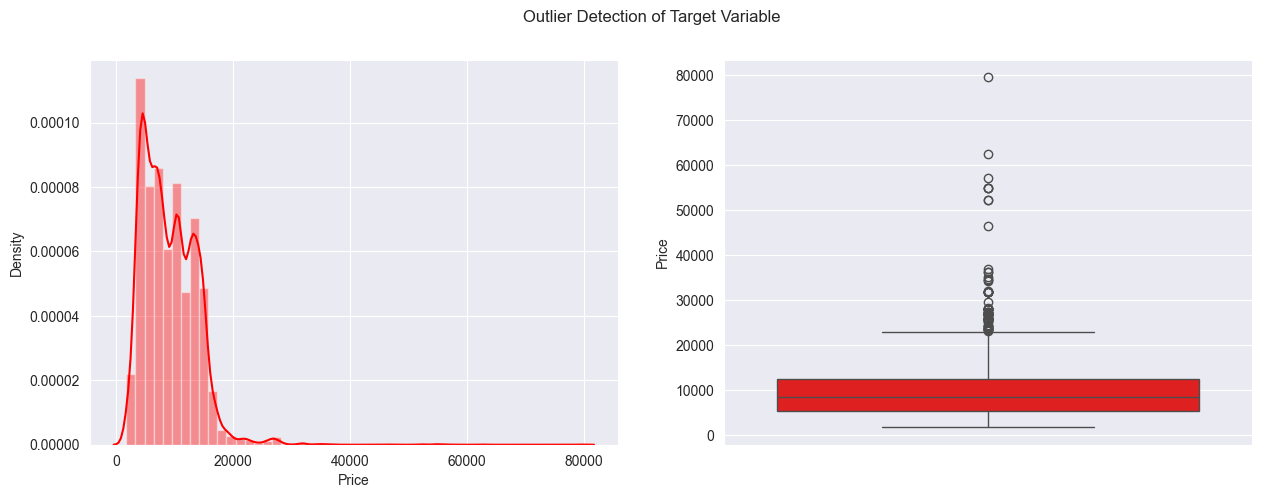

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='r', ax=ax[0])
sns.boxplot (data['Price'], color='r', ax=ax[1])
plt.suptitle('Outlier Detection of Target Variable')
fig.show()

In [132]:
data['Price'] = data['Price'].apply(lambda x:df['Price'].median() if x > 40000 else x)

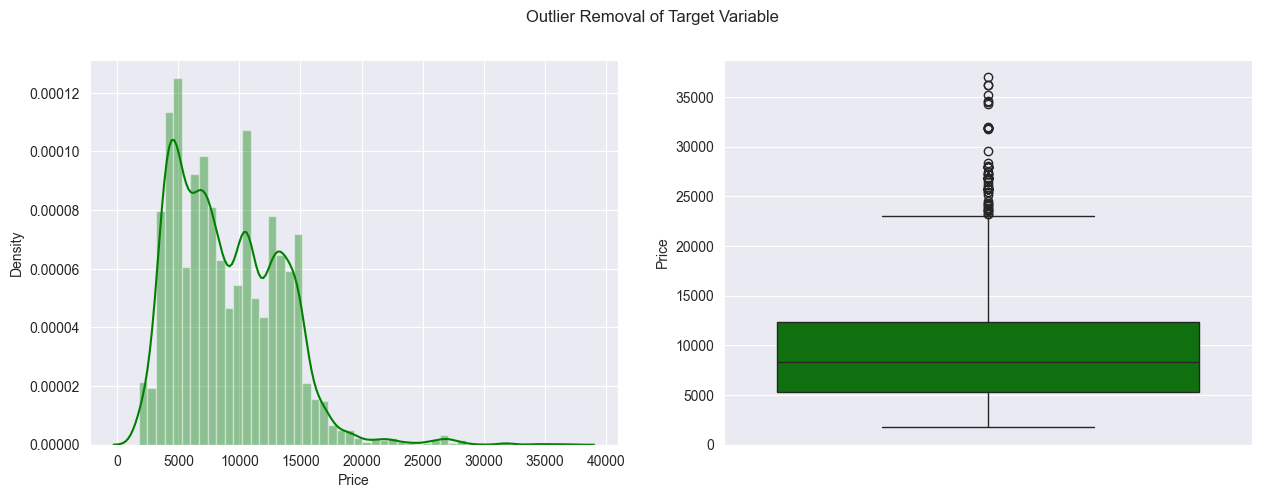

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='g', ax=ax[0])
sns.boxplot (data['Price'], color='g', ax=ax[1])
plt.suptitle('Outlier Removal of Target Variable')
fig.show()

#### Clearly, the outliers have been removed but, the distribution is still not looking good. Therefore let's see what happens if we perform Log Transformation

In [134]:
data['Price'] = np.log(data['Price'])

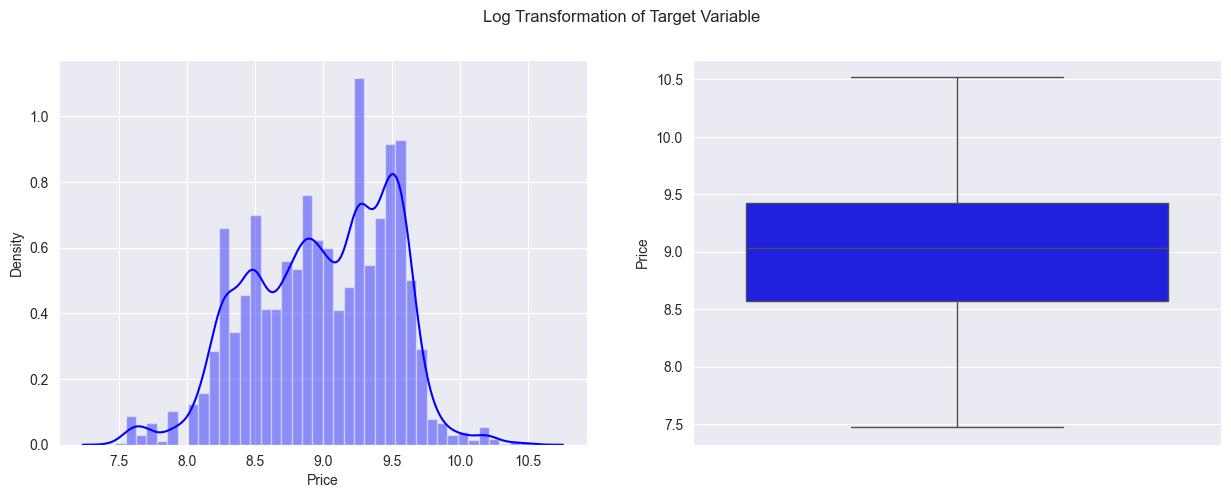

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(data['Price'], color='b', ax=ax[0])
sns.boxplot (data['Price'], color='b', ax=ax[1])
plt.suptitle('Log Transformation of Target Variable')
fig.show()

#### Now, it is looking much better

## Seperating Dependent & Independent Variable

In [136]:
X = data.drop('Price', axis=1)
y = data['Price']

## Splitting Train & Test Dataset

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [138]:
DTR = DecisionTreeRegressor()
model = DTR.fit(X_train, y_train)
print(f'Training Score - {model.score(X_train, y_train)}')
print(f'Testing Score  - {model.score(X_test, y_test)}')

Training Score - 0.9747965828373104
Testing Score  - 0.772636629517101


In [139]:
print(f'Training Score - {model.score(X_train, y_train)}')
print(f'Testing Score  - {model.score(X_test, y_test)}')

Training Score - 0.9747965828373104
Testing Score  - 0.772636629517101


## Saving Model

In [140]:
pickle.dump(model, open('model.pkl', 'wb'))